TODO:
- Run Match on Second Dataset


In [94]:
!pip install nltk
import pandas as pd
import re
import nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [95]:
import os
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [96]:
!ls '/content/gdrive/Shareddrives/CSE 144 DATA/DATA'

'Clean Resume Guara.csv'	     'Job Descriptions Dataset 1.csv'
'Final Job Dataset.csv'		     'Job Descriptions Dataset 2.csv'
 gauravduttakiit_resume-dataset.csv   snehaanbhawal_resume-dataset.csv


### ---- Importing and initializing the resume datasets ----

Out data will be orginized in the follwoing columns:

Category | Original Resume | Cleaned Resume

In [97]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [98]:
# https://www.kaggle.com/datasets/gauravduttakiit/resume-dataset
dataset_1 = pd.read_csv('/content/gdrive/Shareddrives/CSE 144 DATA/DATA/gauravduttakiit_resume-dataset.csv' ,encoding='utf-8')
ds_jobs =  pd.read_csv('/content/gdrive/Shareddrives/CSE 144 DATA/DATA/Final Job Dataset.csv', encoding='utf-8')
# Find empty values (Should be all 0's)
dataset_1.isnull().sum() 
dataset_1.head(1)
#dataset_1.info()
#print ("dataset_1 - Types of resumes\n\n ")
#print (dataset_1['Category'].value_counts())

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...


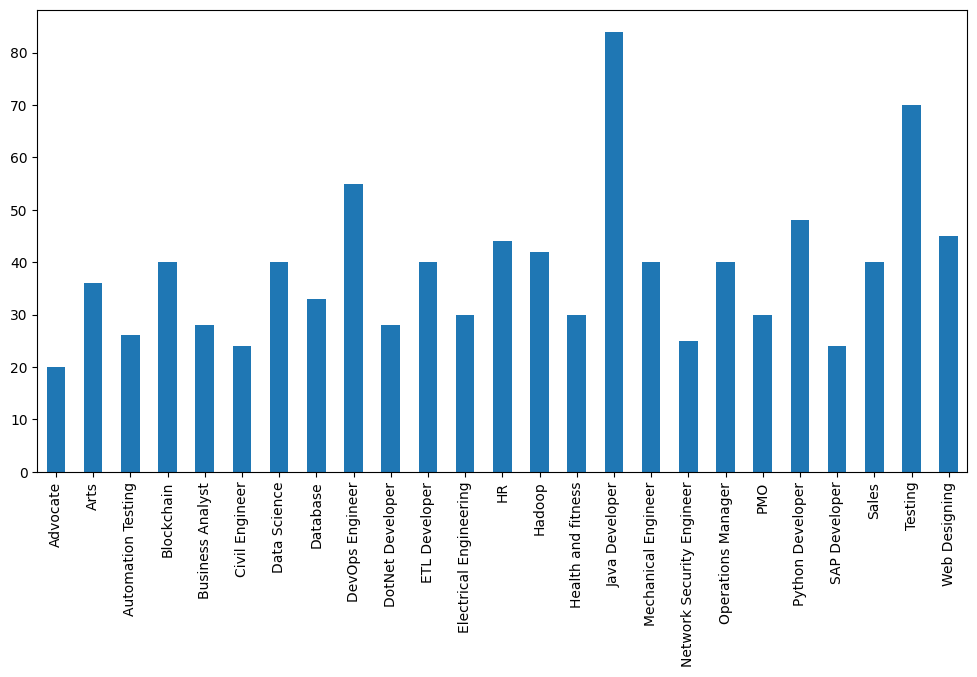

In [99]:
import matplotlib.pyplot as plt
dataset_1.describe()
dataset_1['Category'].value_counts().sort_index().plot(kind='bar', figsize=(12, 6))
plt.show()

In [100]:
# Upload a cleaned csv format file to the gdrive

stop_words = set(stopwords.words('english'))  # Set of English stopwords
html_regex = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')

# Function from: https://www.kaggle.com/code/gauravduttakiit/resume-screening-using-machine-learning
def cleanJobDescription(text):
    text = re.sub('http\S+\s*', ' ', text)                                                     # remove URLs
    text = re.sub(html_regex, '', text)                                                        # remove HTML tags
    text = re.sub('RT|cc', ' ', text)                                                          # remove RT and cc
    text = re.sub('#\S+', '', text)                                                            # remove hashtags
    text = re.sub('@\S+', '  ', text)                                                          # remove mentions
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', text)       # remove punctuations
    text = re.sub(r'[^\x00-\x7f]',r' ', text) 
    text = re.sub('\s+', ' ', text)                                                            # remove extra whitespace

    tokens = nltk.word_tokenize(text)                                                          # Tokenize the text into words
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]              # Remove stopwords
    filtered_text = ' '.join(filtered_tokens)                                                  # Join the filtered tokens back into text

    return filtered_text.replace('\n', ' ')

dataset_1['Resume'] = dataset_1['Resume'].apply(lambda x: cleanJobDescription(x))
dataset_1.to_csv('/content/gdrive/Shareddrives/CSE 144 DATA/DATA/Clean Resume Guara.csv')

In [101]:
# Extracts list of skills from a string
import re
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
def ngrams_tokens(text):
    text_tokens = word_tokenize(text.lower()) # Tokenize
    s = ' '.join([word for word in text_tokens if not word in stopwords.words()]) # Remove stop words
    s = re.sub(r'[^a-zA-Z0-9\s]', ' ', s)  # remove symbols and other unwanted characters
    tokens = [token for token in s.split(" ") if token != ""]
    s_list = list(ngrams(tokens, 1)) # Get ngrams (frequent word occurences)
    for i in range(len(s_list)): #Convert to list of strings
        s_list[i] = s_list[i][0]
    return s_list

In [102]:
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity

def match(resume, job):
    a_vals = Counter(ngrams_tokens(job))
    b_vals = Counter(ngrams_tokens(resume))

    words  = list(a_vals.keys() | b_vals.keys())
    a_vect = [a_vals.get(word, 0) for word in words]       
    b_vect = [b_vals.get(word, 0) for word in words]        

    len_a  = sum(av*av for av in a_vect) ** 0.5             
    len_b  = sum(bv*bv for bv in b_vect) ** 0.5             
    dot    = sum(av*bv for av,bv in zip(a_vect, b_vect))   
    cosine = dot / (len_a * len_b) 
    return cosine
    #print(cosine_similarity([a_vect], [b_vect]))

In [103]:
import random

def find_best_match(text, num_searches=10, is_resume=True):
    assert num_searches >= 1
    best_match = 0
    idx = 0
    for i in range(num_searches):
        rand = random.randint(0, len(dataset_1))
        if is_resume:
            similar = match(text, ds_jobs['Job Description'].values[rand])
        else:
            similar = match(dataset_1['Resume'].values[rand], text)
        if best_match < similar:
            best_match, idx = similar, rand
    return (best_match, idx)

In [107]:
t = find_best_match(dataset_1['Resume'].values[0])
print(f'Best Match %: {t[0]}')
resume = ds_jobs['Job Description'].values[t[1]]
print(f'Resume: {resume}')

Best Match %: 0.34044557857303054
Resume: Senior Manager Advertising Analytics support internal stakeholders quantitative analytics relating WWE digital advertising operations include reporting analysis developing data visualizations interactive dashboards assisting development WWE enterprise data platform supporting business decisions data driven insight Key Responsibilities Work various stakeholder groups including Sales Ad Operations Finance Product Technology understand business objectives inform advertising analytics learning agenda Create maintain weekly monthly reports measuring performance conduct ad hoc deep dive analyses derive insights recommendations Assist development KPIs automated interactive dashboards forecasting models advertising business Partner Data Technology manage requirements data collection data quality structuring blending data multiple tools sources WWE enterprise data platform meet analytical needs Leverage data guide Sales Strategy Leadership maximize inve

In [144]:
import ipywidgets as widgets
Uploaded = widgets.Select(
    options=['Resume', 'Job'],
    description='Uploaded:',
)

Uploaded 

Select(description='Uploaded:', options=('Resume', 'Job'), value='Resume')

In [143]:
# Optional Upload a Job Description and Find a matching Resume
from google.colab import files
import ipywidgets as widgets
from ipywidgets import Box
from ipywidgets import interact
uploaded_file = list(files.upload().keys())[0]
if not uploaded_file.endswith('.txt'):
    print('Only txt files are accepted')
else:
    with open(uploaded_file) as f:
        if Uploaded.value == 'Resume':
            print(find_best_match(f.read())[0])
        else:
            print(find_best_match(f.read(), is_resume=False)[0])

Saving appTest.txt to appTest (12).txt
0.08540755403652867


In [145]:
# https://www.kaggle.com/datasets/snehaanbhawal/resume-dataset

dataset_2 = pd.read_csv('snehaanbhawal_resume-dataset.csv' ,encoding='utf-8')

# Removing the resume_html column. We will not use this.
dataset_2.drop(columns = ['ID', 'Resume_html'], inplace = True)

# Renaming 'Resume_str' column to 'Resume'
dataset_2 = dataset_2.rename(columns={"Resume_str": "Resume"})

# Reordering columns
columnsTitles = ['Category', 'Resume']
dataset_2 = dataset_2.reindex(columns=columnsTitles)

# Adding 'Cleaned_Reume' column
dataset_2['Cleaned_Resume'] = ''

dataset_2.head()
#dataset_2.info()
#print ("dataset_2 - Types of resumes\n\n ")
#print (dataset_2['Category'].value_counts())

FileNotFoundError: ignored

### ----- Cleaning Resumes -----

In [ ]:

# Function from: https://www.kaggle.com/code/gauravduttakiit/resume-screening-using-machine-learning
def cleanResume(resumeText):


    resumeText = re.sub('http\S+\s*', ' ', resumeText)  # remove URLs
    resumeText = re.sub('RT|cc', ' ', resumeText)  # remove RT and cc
    resumeText = re.sub('#\S+', '', resumeText)  # remove hashtags
    resumeText = re.sub('@\S+', '  ', resumeText)  # remove mentions
    resumeText = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', resumeText)  # remove punctuations
    resumeText = re.sub(r'[^\x00-\x7f]',r' ', resumeText) 
    resumeText = re.sub('\s+', ' ', resumeText)  # remove extra whitespace

    # This part from https://www.kaggle.com/code/sanchukanirupama/rf-based-multiclass-resume-classifier
    #resumeText = resumeText.lower() # convert to lowercase
    #resumeText = re.sub('[^a-zA-Z]', ' ', resumeText) # remove non-characters
    #resumeText = nltk.tokenize.word_tokenize(resumeText) # tokenize words
    #resumeText = [w for w in resumeText if not w in nltk.corpus.stopwords.words('english')] # remove stop-words
    #STEMMER = nltk.stem.porter.PorterStemmer()
    #txt = [STEMMER.stem(w) for w in resumeText] # stemming


    return resumeText




In [ ]:
# https://www.kaggle.com/datasets/gauravduttakiit/resume-dataset    
dataset_1['Cleaned_Resume'] = dataset_1.Resume.apply(lambda x: cleanResume(x))
dataset_1.head(1)

In [ ]:
# https://www.kaggle.com/datasets/snehaanbhawal/resume-dataset
dataset_2['Cleaned_Resume'] = dataset_2.Resume.apply(lambda x: cleanResume(x))
dataset_2.head()


### ---- Combining Datasets to One ----

In [ ]:
frames = [dataset_1, dataset_2]
dataset_combo = pd.concat(frames)
#dataset_combo.head()

#print ("Combined datasat - Types of resumes\n\n ")
#print (dataset_combo['Category'].value_counts())



```
# This is formatted as code
```



In [ ]:
# Makes the categories all lower-case
dataset_combo['Category'] = dataset_combo['Category'].apply(str.lower)
dataset_combo.head()

#print ("Combined datasat - Types of resumes\n\n ")
#print (dataset_combo['Category'].value_counts())

In [ ]:
import matplotlib.pyplot as plt
dataset_combo['Category'].value_counts().sort_index().plot(kind='bar', figsize=(12, 6))
plt.show()